

## Train Phase




In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/COMP6471-IS"

In [ ]:
# #changing the working directory
# %cd /content/gdrive/My Drive/COMP6471-IS
# #Check the present working directory using pwd command

/content/gdrive/My Drive/COMP6471-IS


In [ ]:
# Download dataset from https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
#!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
# download cifar dataset for non-human object
#!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders
# https://course.fast.ai/datasets#image-classification
# !kaggle datasets download -d bikashjaiswal/dataset-for-mask-nonmask-and-nonhuman-classes --force

 #### Importing all the necessary libraries



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from tqdm import tqdm
from statistics import mean
import pandas as pd


In [ ]:
# pytorch packages
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
# TO enable GPU. GO to runtime and change runtime type  to 'GPU'. if cuda the GPU is used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [ ]:
#!unzip FaceMaskDataset.zip -d dataset
# !unzip small_v1.zip -d balanced_small_v1
# !unzip small/Validation/Validation.zip -d temp
# !unzip small.zip -d bias_before_balancing
# !unzip balanced_small.zip -d bias_after_balancing


Archive:  balanced_small.zip
   creating: bias_after_balancing/Test/
   creating: bias_after_balancing/Test/WithoutMask/
   creating: bias_after_balancing/Test/WithMask/
   creating: bias_after_balancing/Test/NonHuman/
  inflating: bias_after_balancing/Test/WithoutMask/88.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._88.png  
  inflating: bias_after_balancing/Test/WithoutMask/162.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._162.png  
  inflating: bias_after_balancing/Test/WithoutMask/77.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._77.png  
  inflating: bias_after_balancing/Test/WithoutMask/63.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._63.png  
  inflating: bias_after_balancing/Test/WithoutMask/62.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._62.png  
  inflating: bias_after_balancing/Test/WithoutMask/76.png  
  inflating: bias_after_balancing/__MACOSX/Test/WithoutMask/._76

## Load the Data, Data pre-processing and Data Augmentation

1.   Normalization of all train, test, and validation dataset
2.   Augmentation of Train dataset only.

  1.   rescale all the image to 28x28
  2.   rotate, crop, shear the image





In [ ]:
# training_path = 'dataset/Train'
# valid_path = 'dataset/Validation'
# test_path = 'dataset/Test'

# data_dir = 'dataset'
# data_dir = 'balanced_small_v1'
data_dir = 'bias_after_balancing'

In [ ]:


# data_transforms = transforms.Compose([
#        transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])


# image_datasets = datasets.ImageFolder(data_dir, data_transforms)

# dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4,
#                                              shuffle=True, num_workers=2)
# dataset_sizes =  len(image_datasets)
# class_names = image_datasets.classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# inputs, classes = next(iter(dataloaders))
# print(inputs.shape)
# print(class_names)

data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in tqdm(['Train', 'Validation', 'Test'])}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=2)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Validation', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in tqdm(['Train', 'Validation', 'Test'])}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


inputs, classes = next(iter(dataloaders['Train']))
print(inputs.shape)
print(class_names)


100%|██████████| 3/3 [00:00<00:00, 1634.99it/s]


torch.Size([4, 3, 224, 224])
['NonHuman', 'WithMask', 'WithoutMask']


100%|██████████| 2/2 [00:00<00:00, 11081.38it/s]


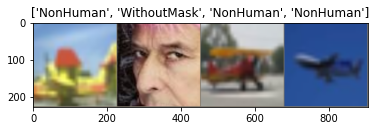

In [ ]:


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = tqdm(next(iter(dataloaders['Train'])))

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train(train_loader, model, optimizer):
    losses = []
    accs = []
    output_labels = np.array([])

    model.train()

    for i, (images, target) in enumerate(tqdm(train_loader,position=0, leave=True)):
        images, target = images.to(device), target.to(device)

        # compute output
        optimizer.zero_grad()

        output = model(images)
        prediction = output.argmax(1)
        output_labels = np.append(output_labels, prediction.cpu().detach().numpy())
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        acc = accuracy(output, target)

        # compute gradient and do SGD step
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        losses.append(loss.item())
        accs.append(acc.item())

   # return losses, accs
    return losses, accs, output_labels

#### Model definition

In [ ]:
class block(nn.Module):
    def __init__(self, filters, subsample = False):
        super().__init__()
        
        s = 0.5 if subsample else 1.0

        # layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # shortcut connection
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            z = z + torch.cat((d, p), dim=1)
        else:
            z = z + x 

        z = self.relu2(z)
        
        return z



class myModel(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # blocks
        self.block1 = nn.ModuleList([block(64, subsample=False) for _ in range(n)])

        # to speed up the computation
        # self.block21 = block(128, subsample=True)
        # self.block22 = nn.ModuleList([block(128, subsample=False) for _ in range(n-1)])

        # self.block31 = block(256, subsample=True)
        # self.block32 = nn.ModuleList([block(256, subsample=False) for _ in range(n-1)])
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.softmax = nn.LogSoftmax(dim=-1)

        # to speed up the computation
        # self.classifier = nn.Sequential(
        #     nn.Dropout(),
        #     nn.Linear(256 , 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, 3),
        # )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 , 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),
        )

        
        # initilise weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu(z)

        for l in self.block1: z = l(z)

        # to speed up the computation
        # z = self.block21(z)
        # for l in self.block22: 
        #     z = l(z)

        # z = self.block31(z)
        # for l in self.block32: 
        #     z = l(z)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.classifier(z)
        return self.softmax(z)



In [ ]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()


my_model = myModel(2)
my_model = my_model.to(device)


In [ ]:
%%time
lr = 0.01
num_epochs = 6
optimizer = torch.optim.SGD(my_model.parameters(), lr=lr)
predicted_labels_train = []
predicted_labels_test = []
for epoch in tqdm(range(0, num_epochs),position=0, leave=True):

        # train phase
        print("\n\n epoch: ",epoch+1,"\n Train Phase")

        # losses, accs, predicted_labels = train(dataloaders['Train'], model_alexnet, optimizer)
        losses, accs, predicted_labels_train = train(dataloaders['Train'], my_model, optimizer)
        # print("   losses",losses)
        print("\n   mean of losses:", mean(losses))
        # print("   accs",accs)
        print("\n   mean of accuracies:", mean(accs))


  0%|          | 0/376 [00:00<?, ?it/s]



 epoch:  1 
 Train Phase


  0%|          | 0/376 [00:00<?, ?it/s]


   mean of losses: 0.9343742458149791

   mean of accuracies: 0.6026152482533709


 epoch:  2 
 Train Phase


  0%|          | 0/376 [00:00<?, ?it/s]


   mean of losses: 0.7280666657941456

   mean of accuracies: 0.675531914893617


 epoch:  3 
 Train Phase


  0%|          | 0/376 [00:00<?, ?it/s]


   mean of losses: 0.724230320490104

   mean of accuracies: 0.6753102837407843


 epoch:  4 
 Train Phase


  0%|          | 0/376 [00:00<?, ?it/s]


   mean of losses: 0.6864125167832096

   mean of accuracies: 0.7209663120831581


 epoch:  5 
 Train Phase


  0%|          | 0/376 [00:00<?, ?it/s]


   mean of losses: 0.6531797579707618

   mean of accuracies: 0.7311613475705715


 epoch:  6 
 Train Phase


100%|██████████| 6/6 [02:22<00:00, 23.75s/it]


   mean of losses: 0.6334864195000302

   mean of accuracies: 0.7386968085106383
CPU times: user 1min 13s, sys: 59.7 s, total: 2min 13s
Wall time: 2min 22s


In [ ]:
# save model

PATH = "bias_after_balancing_sm.pt"
torch.save(my_model.state_dict(), PATH)
